In [1]:
import pandas as pd
import numpy as np
import regex as re
import math
from scipy.stats import mode
import scipy as sc
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customer_df = pd.read_csv('Customer Dataset File.csv', index_col=0)

# Feature Engineering
# General Overview Variables
# customer_df.loc[customer_df.TownSize == '#NULL!','TownSize'] = np.nan
customer_df['TownSize'] = customer_df['TownSize'].replace('#NULL!',np.nan)
customer_df['TownSize'] = customer_df['TownSize'].astype(float)
# customer_df['EquipmentOverTenure'] = pd.to_numeric(customer_df['EquipmentOverTenure'],errors='coerc')

customer_df['Gender'] = customer_df['Gender'].replace(np.nan,'Unknown')
customer_df['JobCategory'] = customer_df['JobCategory'].replace(np.nan,'Unknown')

customer_df['HHIncome'] = customer_df['HHIncome'].str.replace('$','')
customer_df['HHIncome'] = customer_df['HHIncome'].str.replace(',','')
customer_df['HHIncome'] = customer_df['HHIncome'].astype(float)

# Debt Behavior Variables
customer_df['CardSpendMonth'] = customer_df['CardSpendMonth'].str.replace('$','')
customer_df['CardSpendMonth'] = customer_df['CardSpendMonth'].str.replace(',','')
customer_df['CardSpendMonth'] = pd.to_numeric(customer_df['CardSpendMonth'],errors='coerc')

# Telecom Behavior Variables
customer_df['VoiceOverTenure'] = customer_df['VoiceOverTenure'].str.replace('$','')
customer_df['VoiceOverTenure'] = customer_df['VoiceOverTenure'].str.replace(',','')
customer_df['VoiceOverTenure'] = pd.to_numeric(customer_df['VoiceOverTenure'],errors='coerc')
customer_df['VoiceOverTenure'] = customer_df['VoiceOverTenure'].replace(np.nan,0)

customer_df['EquipmentOverTenure'] = customer_df['EquipmentOverTenure'].str.replace('$','')
customer_df['EquipmentOverTenure'] = customer_df['EquipmentOverTenure'].str.replace(',','')
customer_df['EquipmentOverTenure'] = pd.to_numeric(customer_df['EquipmentOverTenure'],errors='coerc')

customer_df['DataOverTenure'] = customer_df['DataOverTenure'].str.replace('$','')
customer_df['DataOverTenure'] = customer_df['DataOverTenure'].str.replace(',','')
customer_df['DataOverTenure'] = pd.to_numeric(customer_df['DataOverTenure'],errors='coerc')

# Convert to per month
customer_df['VoicePerMonth'] = customer_df['VoiceOverTenure']/customer_df['PhoneCoTenure']
customer_df['EquipmentPerMonth'] = customer_df['EquipmentOverTenure']/customer_df['PhoneCoTenure']
customer_df['DataPerMonth'] = customer_df['DataOverTenure']/customer_df['PhoneCoTenure']


In [3]:
def num_missing(x):
  return sum(x.isnull())
#Applying per column:
print(customer_df.apply(num_missing, axis=0))

Region                    0
TownSize                  2
Gender                    0
Age                       0
EducationYears            0
JobCategory               0
UnionMember               0
EmploymentLength          0
Retired                   0
HHIncome                  0
DebtToIncomeRatio         0
CreditDebt                0
OtherDebt                 0
LoanDefault               0
MaritalStatus             0
HouseholdSize             8
NumberPets                6
NumberCats                7
NumberDogs                8
NumberBirds              34
HomeOwner                13
CarsOwned                 0
CarOwnership              0
CarBrand                  0
CarValue                  0
CommuteTime               0
PoliticalPartyMem         0
Votes                     0
CreditCard                0
CardTenure                0
                       ... 
CardSpendMonth            7
ActiveLifestyle           0
PhoneCoTenure             0
VoiceLastMonth            0
VoiceOverTenure     

In [4]:
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded

In [5]:
#Binning continuous variables
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]
  print(break_points)  
  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(1,len(cut_points)+2)
  print(labels)
  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

In [6]:
#Binning Age:
cut_points = [31,47,62]
labels = ["18-31",">31-47",">47-62",">62"]
customer_df["Age_Recoded"] = binning(customer_df["Age"], cut_points,labels)
print (pd.value_counts(customer_df["Age_Recoded"], sort=False))

[18, 31, 47, 62, 79]
['18-31', '>31-47', '>47-62', '>62']
18-31     1253
>31-47    1322
>47-62    1187
>62       1238
Name: Age_Recoded, dtype: int64


In [7]:
customer_df['DataPerMonth_zeros'] = customer_df['DataPerMonth'].replace(np.nan,0.0)
customer_df['DataPerMonth'].describe()

count    1344.000000
mean       37.909473
std        17.588309
min         7.300000
25%        25.925712
50%        34.803256
75%        45.986458
max       181.107746
Name: DataPerMonth, dtype: float64

In [8]:
#Binning DataPerMonth:
cut_points = [7,26,35,46]
labels = ["0","7-26","26-35","35-46",">46"]
customer_df["DataPerMonth_Recoded"] = binning(customer_df["DataPerMonth_zeros"], cut_points,labels)
print (pd.value_counts(customer_df["DataPerMonth_Recoded"], sort=False))

[0.0, 7, 26, 35, 46, 181.10774647887322]
['0', '7-26', '26-35', '35-46', '>46']
0        3656
7-26      339
26-35     343
35-46     326
>46       336
Name: DataPerMonth_Recoded, dtype: int64


In [9]:
customer_df["WirelessData"].value_counts()

No     3656
Yes    1344
Name: WirelessData, dtype: int64

In [10]:
customer_df['HHIncome'].describe()

count    5.000000e+03
mean     5.475960e+04
std      5.537751e+04
min      9.000000e+03
25%      2.400000e+04
50%      3.800000e+04
75%      6.700000e+04
max      1.073000e+06
Name: HHIncome, dtype: float64

In [11]:
#Binning HHIncome:
cut_points = [24000,38000,67000]
labels = ["<$24K","$24K-38K","$38K-67K",">$67K"]
customer_df["HHIncome_Recoded"] = binning(customer_df["HHIncome"], cut_points,labels)
print (pd.value_counts(customer_df["HHIncome_Recoded"], sort=False))

[9000.0, 24000, 38000, 67000, 1073000.0]
['<$24K', '$24K-38K', '$38K-67K', '>$67K']
<$24K       1330
$24K-38K    1192
$38K-67K    1254
>$67K       1224
Name: HHIncome_Recoded, dtype: int64


In [12]:
customer_df['EducationYears'].describe()

count    5000.000000
mean       14.543000
std         3.281083
min         6.000000
25%        12.000000
50%        14.000000
75%        17.000000
max        23.000000
Name: EducationYears, dtype: float64

In [13]:
#Binning EducationYears:
cut_points = [12,14,17]
labels = ["<12","12-14","14-17",">17"]
customer_df["EducationYears_Recoded"] = binning(customer_df["EducationYears"], cut_points,labels)
print (pd.value_counts(customer_df["EducationYears_Recoded"], sort=False))

[6, 12, 14, 17, 23]
['<12', '12-14', '14-17', '>17']
<12      1413
12-14    1100
14-17    1476
>17      1011
Name: EducationYears_Recoded, dtype: int64


In [69]:
customer_df['CardSpendMonth'].describe()

count     5000.000000
mean      3372.025200
std       2451.450683
min          0.000000
25%       1833.775000
50%       2763.600000
75%       4185.375000
max      39264.100000
Name: CardSpendMonth, dtype: float64

In [70]:
#Binning EducationYears:
cut_points = [1800,2800,4200]
labels = ["<1800","1800-2800","2800-4200",">4200"]
customer_df["CardSpendMonth_Recoded"] = binning(customer_df["CardSpendMonth"], cut_points,labels)
print (pd.value_counts(customer_df["CardSpendMonth_Recoded"], sort=False))

[0.0, 1800, 2800, 4200, 39264.1]
['<1800', '1800-2800', '2800-4200', '>4200']
<1800        1205
1800-2800    1337
2800-4200    1218
>4200        1240
Name: CardSpendMonth_Recoded, dtype: int64


In [14]:
customer_df['DebtToIncomeRatio'].describe()

count    5000.000000
mean        9.954160
std         6.399783
min         0.000000
25%         5.100000
50%         8.800000
75%        13.600000
max        43.100000
Name: DebtToIncomeRatio, dtype: float64

In [15]:
#Binning DebtToIncomeRatio:
cut_points = [5.1,8.8,13.6]
labels = ["<5.1","5.1-8.8","8.8-13.6",">13.6"]
customer_df["DebtToIncomeRatio_Recoded"] = binning(customer_df["DebtToIncomeRatio"], cut_points,labels)
print (pd.value_counts(customer_df["DebtToIncomeRatio_Recoded"], sort=False))

[0.0, 5.1, 8.8, 13.6, 43.1]
['<5.1', '5.1-8.8', '8.8-13.6', '>13.6']
<5.1        1251
5.1-8.8     1266
8.8-13.6    1244
>13.6       1239
Name: DebtToIncomeRatio_Recoded, dtype: int64


In [16]:
customer_df['PhoneCoTenure'].describe()

count    5000.000000
mean       38.204800
std        22.661888
min         0.000000
25%        18.000000
50%        38.000000
75%        59.000000
max        72.000000
Name: PhoneCoTenure, dtype: float64

In [17]:
#Binning PhoneCoTenure:
cut_points = [18,38,59]
labels = ["<18","18-38","38-59",">59"]
customer_df["PhoneCoTenure_Recoded"] = binning(customer_df["PhoneCoTenure"], cut_points,labels)
print (pd.value_counts(customer_df["PhoneCoTenure_Recoded"], sort=False))

[0, 18, 38, 59, 72]
['<18', '18-38', '38-59', '>59']
<18      1304
18-38    1213
38-59    1239
>59      1244
Name: PhoneCoTenure_Recoded, dtype: int64


In [18]:
customer_df['TVWatchingHours'].describe()

count    5000.000000
mean       19.645000
std         5.165609
min         0.000000
25%        17.000000
50%        20.000000
75%        23.000000
max        36.000000
Name: TVWatchingHours, dtype: float64

In [19]:
#Binning TVWatchingHours:
cut_points = [17,20,23]
labels = ["<17","17-20","20-23",">23"]
customer_df["TVWatchingHours_Recoded"] = binning(customer_df["TVWatchingHours"], cut_points,labels)
print (pd.value_counts(customer_df["TVWatchingHours_Recoded"], sort=False))

[0, 17, 20, 23, 36]
['<17', '17-20', '20-23', '>23']
<17      1535
17-20    1309
20-23    1112
>23      1044
Name: TVWatchingHours_Recoded, dtype: int64


In [20]:
customer_df['VoicePerMonth'].describe()

count    4997.000000
mean       13.458152
std        12.796867
min         0.500000
25%         5.770588
50%         9.644444
75%        16.481452
max       181.201389
Name: VoicePerMonth, dtype: float64

In [21]:
#Binning TVWatchingHours:
cut_points = [5,10,17]
labels = ["<5","5-10","10-17",">17"]
customer_df["VoicePerMonth_Recoded"] = binning(customer_df["VoicePerMonth"], cut_points,labels)
print (pd.value_counts(customer_df["VoicePerMonth_Recoded"], sort=False))

[0.5, 5, 10, 17, 181.20138888888889]
['<5', '5-10', '10-17', '>17']
<5        991
5-10     1597
10-17    1215
>17      1194
Name: VoicePerMonth_Recoded, dtype: int64


In [22]:
customer_df['Internet'].value_counts()

No     2498
Yes     774
3       598
4       585
2       545
Name: Internet, dtype: int64

In [23]:
customer_df['Internet_Recoded'] = customer_df['Internet'].replace(["4","2","3"],value="Yes")

In [24]:
customer_df['Internet_Recoded'].value_counts()

Yes    2502
No     2498
Name: Internet_Recoded, dtype: int64

In [25]:
#Coding Gender as male: 1, female:2, unknown: 3
print ('Before Coding:')
print (pd.value_counts(customer_df['Gender']))
customer_df['GenderCoded'] = coding(customer_df['Gender'], {'Male':1,'Female':2,'Unknown':3})
print ('\nAfter Coding:')
print (pd.value_counts(customer_df['GenderCoded']))

Before Coding:
Female     2494
Male       2473
Unknown      33
Name: Gender, dtype: int64

After Coding:
2    2494
1    2473
3      33
Name: GenderCoded, dtype: int64


In [26]:
#Coding JobCategory as Professional:1, Sales:2, Labor:3, Service:4, Crafts:5, Agriculture:6, Unknown: 7
print ('Before Coding:')
print (pd.value_counts(customer_df['JobCategory']))
customer_df['JobCategoryCoded'] = coding(customer_df['JobCategory'], {'Professional':1,'Sales':2,'Labor':3,'Service':4,
                                                                     'Crafts':5,'Agriculture':6,'Unknown':7})
print ('\nAfter Coding:')
print (pd.value_counts(customer_df['JobCategoryCoded']))

Before Coding:
Sales           1635
Professional    1380
Labor            686
Service          620
Crafts           452
Agriculture      212
Unknown           15
Name: JobCategory, dtype: int64

After Coding:
2    1635
1    1380
3     686
4     620
5     452
6     212
7      15
Name: JobCategoryCoded, dtype: int64


In [27]:
#Recoding LoanDefault_num as a numeric variable 
customer_df["LoanDefaultCoded"] = coding(customer_df["LoanDefault"], {'No':2,'Yes':1})
print ('\nAfter Coding:')
print (pd.value_counts(customer_df["LoanDefaultCoded"]))


After Coding:
2    3829
1    1171
Name: LoanDefaultCoded, dtype: int64


In [28]:
#Recoding LoanDefault_num as a numeric variable 
customer_df["MultilineCoded"] = coding(customer_df["Multiline"], {'No':2,'Yes':1})
print ('\nAfter Coding:')
print (pd.value_counts(customer_df["MultilineCoded"]))


After Coding:
2    2558
1    2442
Name: MultilineCoded, dtype: int64


In [29]:
#Replace missing character values with the mode of the distribution 
#cust_df['HouseholdSize'].fillna(mode(cust_df['HouseholdSize']).mode[0], inplace=True)
customer_df['TownSize'].fillna(mode(customer_df['TownSize']).mode[0], inplace=True)                                                
customer_df['TownSize'].isnull().sum()

0

In [30]:
#Replace missing character values with 0
customer_df['CardSpendMonth'].fillna(0.0, inplace=True)                                                
customer_df['TownSize'].isnull().sum()

0

In [31]:
#Selecting the columns or variables that you want to use for clustering
customer_df_kmeans = customer_df[[
    'Age',
    'TownSize',
    'Region',
    'GenderCoded',
    'JobCategoryCoded',
    'HHIncome',
    'EducationYears',
    'DebtToIncomeRatio',
    'CardSpendMonth',
    'LoanDefaultCoded',
    'PhoneCoTenure']]
customer_df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 3964-QJWTRG-NPN to 8027-EXDZBF-OGR
Data columns (total 11 columns):
Age                  5000 non-null int64
TownSize             5000 non-null float64
Region               5000 non-null int64
GenderCoded          5000 non-null int64
JobCategoryCoded     5000 non-null int64
HHIncome             5000 non-null float64
EducationYears       5000 non-null int64
DebtToIncomeRatio    5000 non-null float64
CardSpendMonth       5000 non-null float64
LoanDefaultCoded     5000 non-null int64
PhoneCoTenure        5000 non-null int64
dtypes: float64(4), int64(7)
memory usage: 468.8+ KB


In [155]:
customer_df_kmeans.head()

,Age,TownSize,Region,GenderCoded,JobCategoryCoded,HHIncome,EducationYears,DebtToIncomeRatio,CardSpendMonth,LoanDefaultCoded,PhoneCoTenure
CustomerID,,,,,,,,,,,
3964-QJWTRG-NPN,20,2.0,1,2,1,31000.0,15,11.1,816.6,1,5
0648-AIPJSP-UVM,22,5.0,5,1,2,15000.0,17,18.6,426.0,1,39
5195-TLUDJE-HVO,67,4.0,3,2,2,35000.0,14,9.9,1842.2,2,65
4459-VLPQUH-3OL,23,3.0,4,1,2,20000.0,16,5.7,3409.9,1,36
8158-SMTQFB-CNO,26,2.0,2,1,2,23000.0,16,1.7,2551.0,2,21


In [32]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cust_kmeans_scaled = scaler.fit_transform(customer_df_kmeans)
#Assign the scaled data to a DataFrame using the index keyword arguments
cust_kmeans_scaled_df = pd.DataFrame(cust_kmeans_scaled, index = customer_df_kmeans.index)
cust_kmeans_scaled_df.head()

C:\Users\clnau\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\clnau\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0,1,2,3,4,5,6,7,8,9,10
CustomerID,,,,,,,,,,,
3964-QJWTRG-NPN,-1.520979,-0.481522,-1.407832,0.951471,-1.065594,-0.429091,0.139297,0.179061,-1.042518,-1.808274,-1.465373
0648-AIPJSP-UVM,-1.408420,1.622418,1.405863,-0.998265,-0.384703,-0.718046,0.748913,1.351093,-1.201868,-1.808274,0.035093
5195-TLUDJE-HVO,1.124143,0.921105,-0.000985,0.951471,-0.384703,-0.356852,-0.165511,-0.008464,-0.624111,0.553014,1.182509
4459-VLPQUH-3OL,-1.352141,0.219792,0.702439,-0.998265,-0.384703,-0.627747,0.444105,-0.664801,0.015451,-1.808274,-0.097301
8158-SMTQFB-CNO,-1.183304,-0.481522,-0.704409,-0.998265,-0.384703,-0.573568,0.444105,-1.289885,-0.334948,0.553014,-0.759271


In [33]:
# statistics of scaled data
pd.DataFrame(cust_kmeans_scaled_df).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,1.984191e-16,1.223466e-16,-2.098764e-17,1.308731e-16,2.286615e-16,7.828183e-17,-3.018474e-16,-4.884981e-18,-1.127987e-17,-5.562439e-16,9.363621e-17
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-1.633537e+00,-1.182835e+00,-1.407832e+00,-9.982650e-01,-1.065594e+00,-8.264036e-01,-2.603974e+00,-1.555546e+00,-1.375660e+00,-1.808274e+00,-1.686030e+00
25%,-9.019076e-01,-1.182835e+00,-7.044086e-01,-9.982650e-01,-1.065594e+00,-5.555085e-01,-7.751265e-01,-7.585640e-01,-6.275484e-01,5.530135e-01,-8.916654e-01
50%,-1.440747e-03,2.197916e-01,-9.847933e-04,9.514714e-01,-3.847033e-01,-3.026730e-01,-1.655107e-01,-1.803616e-01,-2.482147e-01,5.530135e-01,-9.038103e-03
75%,8.427469e-01,9.211048e-01,7.024390e-01,9.514714e-01,9.770782e-01,2.210577e-01,7.489131e-01,5.697388e-01,3.318162e-01,5.530135e-01,9.177205e-01
max,1.799493e+00,1.622418e+00,1.405863e+00,2.901208e+00,3.019751e+00,1.838909e+01,2.577761e+00,5.179731e+00,1.464262e+01,5.530135e-01,1.491428e+00


Text(0, 0.5, 'Inertia')

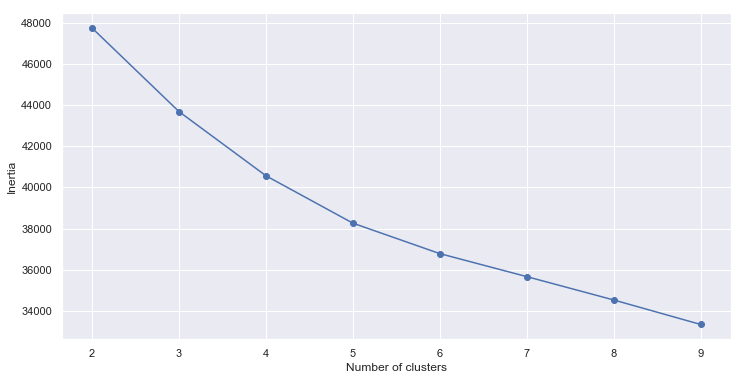

In [34]:
# Plot inertia for multiple cluster solutions against the number of clusters
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(2,10):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(cust_kmeans_scaled_df)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
cust_df_frame = pd.DataFrame({'Cluster':range(2,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(cust_df_frame['Cluster'], cust_df_frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [35]:
# Defining the kmeans function with initialization as k-means++; # You want to cluster into 5 segments
kmeans_5 = KMeans(n_clusters = 5, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans_5.fit(cust_kmeans_scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [36]:
# Inertia calculates the sum of all the points within a cluster from the centroid of that cluster.
# Determine inertia on the fitted data
kmeans_5.inertia_

38260.47897098522

In [37]:
pred_clus5 = kmeans_5.predict(cust_kmeans_scaled_df)
pred_clus5

array([4, 4, 1, ..., 2, 2, 1])

In [38]:
cust_df_frame_2 = pd.DataFrame(cust_kmeans_scaled_df)
cust_df_frame_2['cluster'] = pred_clus5
cust_df_frame_2['cluster'].value_counts()

3    1291
0    1211
4    1068
1    1047
2     383
Name: cluster, dtype: int64

In [39]:
# Using head shows the data structure of the resulting data frame
# There are 10 variables used for clustering and their scaled values are shown
# The last column is the cluster solution and shows the cluster to which obsevation belongs
# There are five segments starting from 0 to 4
cust_df_frame_2.head(5)

,0,1,2,3,4,5,6,7,8,9,10,cluster
CustomerID,,,,,,,,,,,,
3964-QJWTRG-NPN,-1.520979,-0.481522,-1.407832,0.951471,-1.065594,-0.429091,0.139297,0.179061,-1.042518,-1.808274,-1.465373,4
0648-AIPJSP-UVM,-1.408420,1.622418,1.405863,-0.998265,-0.384703,-0.718046,0.748913,1.351093,-1.201868,-1.808274,0.035093,4
5195-TLUDJE-HVO,1.124143,0.921105,-0.000985,0.951471,-0.384703,-0.356852,-0.165511,-0.008464,-0.624111,0.553014,1.182509,1
4459-VLPQUH-3OL,-1.352141,0.219792,0.702439,-0.998265,-0.384703,-0.627747,0.444105,-0.664801,0.015451,-1.808274,-0.097301,4
8158-SMTQFB-CNO,-1.183304,-0.481522,-0.704409,-0.998265,-0.384703,-0.573568,0.444105,-1.289885,-0.334948,0.553014,-0.759271,0


In [40]:
# Get the cluster centroids
print(kmeans_5.cluster_centers_)

[[-0.69945116 -0.18178548 -0.16000964 -0.0089186  -0.06223521 -0.2701298
   0.06510717 -0.3730442  -0.12727409  0.55301354 -0.84068855]
 [ 0.37927768  0.99887951  0.91158317 -0.02339684  0.02278966 -0.05446463
  -0.0099013  -0.15892295 -0.12008859  0.53043909  0.45062844]
 [ 0.52579083 -0.11163845  0.10186568 -0.14302818  0.39040996  2.15438628
   0.45683863 -0.02474355  1.84750554  0.05979421  0.64129457]
 [ 0.87535486 -0.64123205 -0.59815945  0.05891194  0.0535773  -0.14627701
  -0.33054613  0.05531572 -0.22867833  0.52923605  0.76748246]
 [-0.824392    0.04314994 -0.02469571  0.01311508 -0.15646462 -0.23587923
   0.1715475   0.52099921 -0.12406557 -1.80827399 -0.64501733]]


In [49]:
# Create a new data column cluster5_2 to incorporate a cluster indicator variable running from 1 to 5
cust_df_frame_2['segment'] = cust_df_frame_2['cluster'] + 1
cust_df_frame_2.head(5)

,0,1,2,3,4,5,6,7,8,9,10,cluster,cluster5_2,segment
CustomerID,,,,,,,,,,,,,,
3964-QJWTRG-NPN,-1.520979,-0.481522,-1.407832,0.951471,-1.065594,-0.429091,0.139297,0.179061,-1.042518,-1.808274,-1.465373,4,5,5
0648-AIPJSP-UVM,-1.408420,1.622418,1.405863,-0.998265,-0.384703,-0.718046,0.748913,1.351093,-1.201868,-1.808274,0.035093,4,5,5
5195-TLUDJE-HVO,1.124143,0.921105,-0.000985,0.951471,-0.384703,-0.356852,-0.165511,-0.008464,-0.624111,0.553014,1.182509,1,2,2
4459-VLPQUH-3OL,-1.352141,0.219792,0.702439,-0.998265,-0.384703,-0.627747,0.444105,-0.664801,0.015451,-1.808274,-0.097301,4,5,5
8158-SMTQFB-CNO,-1.183304,-0.481522,-0.704409,-0.998265,-0.384703,-0.573568,0.444105,-1.289885,-0.334948,0.553014,-0.759271,0,1,1


Text(0, 0.5, 'Town Size (Scaled)')

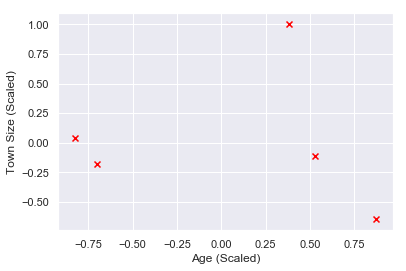

In [158]:
plt.scatter(kmeans_5.cluster_centers_[:, 0], kmeans_5.cluster_centers_[:, 1], c='red', marker='x')
plt.xlabel('Age (Scaled)')
plt.ylabel('Town Size (Scaled)')

Text(0, 0.5, 'Phone Co Tenure (Scaled)')

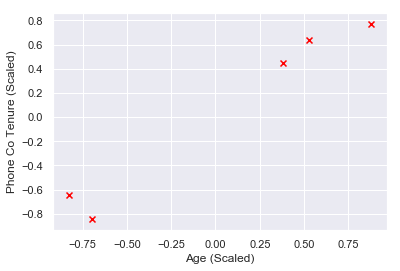

In [159]:
plt.scatter(kmeans_5.cluster_centers_[:, 0], kmeans_5.cluster_centers_[:, 10], c='red', marker='x')
plt.xlabel('Age (Scaled)')
plt.ylabel('Phone Co Tenure (Scaled)')

In [123]:
# Joining the clusters from kmeans to the original data used for clustering
cust_df_clus5_ALL = pd.DataFrame(pd.concat([cust_df_frame_2, customer_df], axis = 1))
cust_df_clus5_ALL.shape

(5000, 90)

In [ ]:
cust_df_clus5_ALL

In [53]:
##Crossstab results
# Using pandas crosstabs to create a cross tab of clusters by loan defaults
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['Age_Recoded'],margins=True, normalize = 'columns')
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['Age_Recoded'],margins=True, normalize = 'index').round(3)*100


Age_Recoded,18-31,>31-47,>47-62,>62
segment,,,,
1,45.0,40.8,12.7,1.5
2,7.0,28.8,31.5,32.7
3,2.9,16.4,50.4,30.3
4,0.7,11.9,31.1,56.3
5,57.6,29.0,10.1,3.3
All,25.1,24.8,23.7,26.4


In [111]:
# Pivot Tables
cust_df_clus5_ALL.pivot_table(values=["Age"], index=['cluster5_2'], aggfunc=np.mean).round(1)


,Age
cluster5_2,
1,34.6
2,53.7
3,56.4
4,62.6
5,32.4


In [55]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['LoanDefault'],margins=True, normalize = 'columns')
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['LoanDefault'],margins=True, normalize = 'index').round(3)*100


LoanDefault,No,Yes
segment,,
1,100.0,0.0
2,99.0,1.0
3,79.1,20.9
4,99.0,1.0
5,0.0,100.0
All,76.6,23.4


In [56]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['Region'],margins=True, normalize = 'columns')
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['Region'],margins=True, normalize = 'index').round(3)*100


Region,1,2,3,4,5
segment,,,,,
1,21.6,23.5,22.7,20.4,11.8
2,0.6,3.9,13.8,28.6,53.1
3,16.2,17.0,24.8,20.1,21.9
4,36.4,28.7,21.8,9.8,3.4
5,19.6,22.0,19.4,20.3,18.7
All,20.2,19.9,20.1,19.3,20.5


In [57]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['TownSize'],margins=True, normalize = 'columns')
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['TownSize'],margins=True, normalize = 'index').round(3)*100


TownSize,1.0,2.0,3.0,4.0,5.0
segment,,,,,
1,30.4,25.4,21.7,16.1,6.4
2,0.4,6.2,18.7,31.3,43.4
3,29.8,24.8,19.6,14.6,11.2
4,51.2,28.4,13.3,6.3,0.9
5,27.2,20.0,18.8,18.4,15.4
All,28.8,21.0,18.1,17.1,15.0


In [112]:
# Pivot Tables
cust_df_clus5_ALL.pivot_table(values=["TownSize"], index=['cluster5_2'], aggfunc=np.mean).round(1)

,TownSize
cluster5_2,
1,2.4
2,4.1
3,2.5
4,1.8
5,2.7


In [58]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['Gender'],margins=True, normalize = 'columns')
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['Gender'],margins=True, normalize = 'index').round(3)*100


Gender,Female,Male,Unknown
segment,,,
1,49.5,49.9,0.6
2,47.9,51.0,1.1
3,43.3,56.4,0.3
4,53.4,46.2,0.4
5,50.2,49.0,0.8
All,49.9,49.5,0.7


In [59]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['JobCategory'],margins=True, normalize = 'columns')
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['JobCategory'],margins=True, normalize = 'index').round(3)*100

JobCategory,Agriculture,Crafts,Labor,Professional,Sales,Service,Unknown
segment,,,,,,,
1,3.7,9.3,11.0,28.7,36.5,10.5,0.2
2,4.3,8.2,14.4,26.4,31.7,15.0,0.0
3,7.3,14.9,22.2,22.2,13.8,19.3,0.3
4,5.0,9.5,17.0,27.0,29.5,11.5,0.6
5,2.8,6.9,9.2,30.2,40.0,10.6,0.3
All,4.2,9.0,13.7,27.6,32.7,12.4,0.3


In [60]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['JobCategory'],margins=True, normalize = 'columns').round(3)*100


JobCategory,Agriculture,Crafts,Labor,Professional,Sales,Service,Unknown,All
segment,,,,,,,,
1,21.2,25.0,19.4,25.2,27.0,20.5,20.0,24.2
2,21.2,19.0,22.0,20.0,20.3,25.3,0.0,20.9
3,13.2,12.6,12.4,6.2,3.2,11.9,6.7,7.7
4,30.2,27.0,31.9,25.2,23.3,24.0,53.3,25.8
5,14.2,16.4,14.3,23.4,26.1,18.2,20.0,21.4


In [61]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['HHIncome_Recoded'],margins=True, normalize = 'columns').round(3)*100
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['HHIncome_Recoded'],margins=True, normalize = 'index').round(3)*100

HHIncome_Recoded,<$24K,$24K-38K,$38K-67K,>$67K
segment,,,,
1,29.0,33.2,25.8,12.1
2,19.1,24.2,30.9,25.8
3,0.3,1.0,7.6,91.1
4,32.5,18.3,25.4,23.8
5,33.5,27.8,24.4,14.2
All,23.8,26.6,24.5,25.1


In [114]:
cust_df_clus5_ALL.pivot_table(values=["HHIncome"], index=['cluster5_2'], aggfunc=np.mean).round(1)

,HHIncome
cluster5_2,
1,39813.4
2,51719.2
3,174052.2
4,46660.0
5,41698.5


In [62]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['HHIncome_Recoded'],margins=True, normalize = 'columns').round(3)*100


HHIncome_Recoded,<$24K,$24K-38K,$38K-67K,>$67K,All
segment,,,,,
1,26.4,33.7,24.9,11.9,24.2
2,15.0,21.2,25.8,22.1,20.9
3,0.1,0.3,2.3,28.5,7.7
4,31.6,19.8,26.2,25.1,25.8
5,26.9,24.9,20.8,12.4,21.4


In [63]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['EducationYears_Recoded'],margins=True, normalize = 'index').round(3)*100

EducationYears_Recoded,<12,12-14,14-17,>17
segment,,,,
1,24.4,23.5,31.3,20.7
2,28.0,21.9,30.5,19.7
3,14.6,16.7,33.9,34.7
4,43.4,19.9,23.7,13.0
5,19.5,24.8,32.0,23.7
All,29.5,22.0,28.3,20.2


In [64]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['EducationYears_Recoded'],margins=True, normalize = 'columns').round(3)*100

EducationYears_Recoded,<12,12-14,14-17,>17,All
segment,,,,,
1,20.9,25.9,25.7,24.8,24.2
2,20.7,20.8,21.6,20.4,20.9
3,4.0,5.8,8.8,13.2,7.7
4,39.6,23.4,20.7,16.6,25.8
5,14.7,24.1,23.2,25.0,21.4


In [115]:
cust_df_clus5_ALL.pivot_table(values=["EducationYears"], index=['cluster5_2'], aggfunc=np.mean).round(1)

,EducationYears
cluster5_2,
1,14.8
2,14.5
3,16.0
4,13.5
5,15.1


In [66]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['DebtToIncomeRatio_Recoded'],margins=True, normalize = 'index').round(3)*100

DebtToIncomeRatio_Recoded,<5.1,5.1-8.8,8.8-13.6,>13.6
segment,,,,
1,36.8,28.7,20.9,13.5
2,27.9,28.2,25.6,18.3
3,28.2,21.7,25.1,25.1
4,21.0,26.7,26.1,26.2
5,12.5,18.3,27.2,42.0
All,24.8,24.9,25.0,25.3


In [67]:
pd.crosstab(cust_df_clus5_ALL['segment'],cust_df_clus5_ALL['DebtToIncomeRatio_Recoded'],margins=True, normalize = 'columns').round(3)*100

DebtToIncomeRatio_Recoded,<5.1,5.1-8.8,8.8-13.6,>13.6,All
segment,,,,,
1,35.7,27.5,20.3,13.2,24.2
2,23.3,23.3,21.5,15.5,20.9
3,8.6,6.6,7.7,7.7,7.7
4,21.7,27.3,27.1,27.3,25.8
5,10.7,15.4,23.3,36.2,21.4


In [117]:
cust_df_clus5_ALL.pivot_table(values=["DebtToIncomeRatio"], index=['cluster5_2'], aggfunc=np.mean).round(1)

,DebtToIncomeRatio
cluster5_2,
1,7.6
2,8.9
3,9.8
4,10.3
5,13.3


In [72]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['CardSpendMonth_Recoded'],margins=True, normalize = 'index').round(3)*100

CardSpendMonth_Recoded,<1800,1800-2800,2800-4200,>4200
segment,,,,
1,23.8,29.4,26.7,20.1
2,25.3,25.1,27.3,22.3
3,1.0,5.0,12.3,81.7
4,29.3,30.4,23.1,17.2
5,25.3,28.7,24.7,21.3
All,24.1,26.7,24.4,24.8


In [118]:
cust_df_clus5_ALL.pivot_table(values=["CardSpendMonth"], index=['cluster5_2'], aggfunc=np.mean).round(1)

,CardSpendMonth
cluster5_2,
1,3058.8
2,3079.1
3,7900.6
4,2811.5
5,3067.9


In [73]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['PhoneCoTenure_Recoded'],margins=True, normalize = 'index').round(3)*100

PhoneCoTenure_Recoded,<18,18-38,38-59,>59
segment,,,,
1,55.7,34.0,9.7,0.7
2,6.4,23.3,35.8,34.5
3,5.2,17.8,29.5,47.5
4,1.5,13.6,35.6,49.3
5,49.0,29.3,16.4,5.3
All,26.1,24.9,24.3,24.8


In [74]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['PhoneCoTenure_Recoded'],margins=True, normalize = 'columns').round(3)*100

PhoneCoTenure_Recoded,<18,18-38,38-59,>59,All
segment,,,,,
1,51.7,34.0,9.4,0.6,24.2
2,5.1,20.1,30.3,29.0,20.9
3,1.5,5.6,9.1,14.6,7.7
4,1.5,14.5,37.0,51.1,25.8
5,40.1,25.8,14.1,4.6,21.4


In [119]:
cust_df_clus5_ALL.pivot_table(values=["PhoneCoTenure"], index=['cluster5_2'], aggfunc=np.mean).round(1)

,PhoneCoTenure
cluster5_2,
1,19.1
2,48.4
3,52.7
4,55.6
5,23.6


In [ ]:
## Profiling Variables

In [75]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['OwnsMobileDevice'],margins=True, normalize = 'columns').round(3)*100

OwnsMobileDevice,No,Yes,All
segment,,,
1,20.6,28.2,24.2
2,23.1,18.6,20.9
3,7.4,7.9,7.7
4,32.0,19.1,25.8
5,16.9,26.2,21.4


In [76]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['OwnsMobileDevice'],margins=True, normalize = 'index').round(3)*100

OwnsMobileDevice,No,Yes
segment,,
1,44.3,55.7
2,57.4,42.6
3,50.4,49.6
4,64.5,35.5
5,41.3,58.7
All,52.1,47.9


In [77]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['OwnsPC'],margins=True, normalize = 'columns').round(3)*100

OwnsPC,No,Yes,All
segment,,,
1,21.2,26.0,24.2
2,21.4,20.7,20.9
3,6.2,8.5,7.7
4,33.3,21.5,25.8
5,18.0,23.3,21.4


In [78]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['OwnsPC'],margins=True, normalize = 'index').round(3)*100

OwnsPC,No,Yes
segment,,
1,32.1,67.9
2,37.4,62.6
3,29.5,70.5
4,47.4,52.6
5,30.9,69.1
All,36.7,63.3


In [79]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['OwnsGameSystem'],margins=True, normalize = 'columns').round(3)*100

OwnsGameSystem,No,Yes,All
segment,,,
1,20.2,28.7,24.2
2,22.7,19.0,20.9
3,7.5,7.8,7.7
4,32.9,18.0,25.8
5,16.7,26.5,21.4


In [80]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['OwnsGameSystem'],margins=True, normalize = 'index').round(3)*100

OwnsGameSystem,No,Yes
segment,,
1,43.8,56.2
2,56.9,43.1
3,51.4,48.6
4,66.9,33.1
5,41.1,58.9
All,52.5,47.5


In [81]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['OwnsFax'],margins=True, normalize = 'columns').round(3)*100

OwnsFax,No,Yes,All
segment,,,
1,24.3,23.9,24.2
2,21.2,19.8,20.9
3,6.4,13.5,7.7
4,27.2,19.4,25.8
5,20.9,23.4,21.4


In [82]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['OwnsFax'],margins=True, normalize = 'index').round(3)*100

OwnsFax,No,Yes
segment,,
1,82.3,17.7
2,83.1,16.9
3,68.4,31.6
4,86.6,13.4
5,80.4,19.6
All,82.1,17.9


In [83]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['NewsSubscriber'],margins=True, normalize = 'columns').round(3)*100

NewsSubscriber,No,Yes,All
segment,,,
1,35.7,11.4,24.2
2,15.8,26.7,20.9
3,5.0,10.7,7.7
4,14.5,38.4,25.8
5,29.0,12.9,21.4


In [84]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['NewsSubscriber'],margins=True, normalize = 'index').round(3)*100

NewsSubscriber,No,Yes
segment,,
1,77.8,22.2
2,39.8,60.2
3,34.2,65.8
4,29.7,70.3
5,71.5,28.5
All,52.7,47.3


In [86]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['TVWatchingHours_Recoded'],margins=True, normalize = 'columns').round(3)*100

TVWatchingHours_Recoded,<17,17-20,20-23,>23,All
segment,,,,,
1,23.3,26.8,23.7,22.9,24.2
2,20.8,22.1,20.4,20.2,20.9
3,7.8,7.0,7.8,8.1,7.7
4,26.6,23.1,27.1,26.7,25.8
5,21.5,20.9,21.0,22.0,21.4


In [87]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['TVWatchingHours_Recoded'],margins=True, normalize = 'index').round(3)*100

TVWatchingHours_Recoded,<17,17-20,20-23,>23
segment,,,,
1,29.6,29.0,21.7,19.7
2,30.6,27.6,21.7,20.2
3,31.1,24.0,22.7,22.2
4,31.6,23.5,23.3,21.6
5,30.9,25.7,21.9,21.5
All,30.7,26.2,22.2,20.9


In [90]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['Internet_Recoded'],margins=True, normalize = 'columns').round(3)*100

Internet_Recoded,No,Yes,All
segment,,,
1,22.5,26.0,24.2
2,21.9,20.0,20.9
3,6.2,9.1,7.7
4,30.8,20.9,25.8
5,18.7,24.1,21.4


In [91]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['Internet_Recoded'],margins=True, normalize = 'index').round(3)*100

Internet_Recoded,No,Yes
segment,,
1,46.3,53.7
2,52.2,47.8
3,40.5,59.5
4,59.6,40.4
5,43.6,56.4
All,50.0,50.0


In [92]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['VM'],margins=True, normalize = 'columns').round(3)*100

VM,No,Yes,All
segment,,,
1,24.1,24.6,24.2
2,21.3,20.2,20.9
3,6.5,10.4,7.7
4,28.2,20.4,25.8
5,20.0,24.5,21.4


In [93]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['VM'],margins=True, normalize = 'index').round(3)*100

VM,No,Yes
segment,,
1,69.3,30.7
2,70.8,29.2
3,59.0,41.0
4,76.1,23.9
5,65.3,34.7
All,69.7,30.3


In [94]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['DataPerMonth_Recoded'],margins=True, normalize = 'columns').round(3)*100

DataPerMonth_Recoded,0,7-26,26-35,35-46,>46,All
segment,,,,,,
1,23.5,45.4,24.5,20.2,14.6,24.2
2,21.7,10.0,17.5,20.9,26.8,20.9
3,6.0,4.4,10.8,15.3,18.5,7.7
4,28.2,6.8,20.1,25.5,25.0,25.8
5,20.6,33.3,27.1,18.1,15.2,21.4


In [95]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['DataPerMonth_Recoded'],margins=True, normalize = 'index').round(3)*100

DataPerMonth_Recoded,0,7-26,26-35,35-46,>46
segment,,,,,
1,70.9,12.7,6.9,5.5,4.0
2,75.9,3.2,5.7,6.5,8.6
3,57.2,3.9,9.7,13.1,16.2
4,79.9,1.8,5.3,6.4,6.5
5,70.4,10.6,8.7,5.5,4.8
All,73.1,6.9,6.5,6.8,6.7


In [133]:
cust_df_clus5_ALL.pivot_table(values=["DataPerMonth_zeros"], index=['cluster5_2','Age_Recoded'], aggfunc=np.mean).round(2)

DataPerMonth_zeros
cluster5_2 Age_Recoded                    
1          18-31                      8.77
           >31-47                    10.02
           >47-62                     8.83
           >62                        5.79
2          18-31                     12.04
           >31-47                    11.81
           >47-62                     9.78
           >62                        9.63
3          18-31                     32.58
           >31-47                    19.84
           >47-62                    19.17
           >62                       18.48
4          18-31                      7.00
           >31-47                    11.55
           >47-62                    11.30
           >62                        6.47
5          18-31                      8.58
           >31-47                    11.47
           >47-62                    10.08
           >62                        9.80

In [127]:
cust_df_clus5_ALL.pivot_table(values=["DataPerMonth_zeros"], index=['cluster5_2'], aggfunc=np.mean).round(1)

,DataPerMonth_zeros
cluster5_2,
1,9.2
2,10.5
3,19.5
4,8.6
5,9.6


In [96]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['WirelessData'],margins=True, normalize = 'columns').round(3)*100

WirelessData,No,Yes,All
segment,,,
1,23.5,26.3,24.2
2,21.7,18.8,20.9
3,6.0,12.2,7.7
4,28.2,19.3,25.8
5,20.6,23.5,21.4


In [97]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['WirelessData'],margins=True, normalize = 'index').round(3)*100

WirelessData,No,Yes
segment,,
1,70.9,29.1
2,75.9,24.1
3,57.2,42.8
4,79.9,20.1
5,70.4,29.6
All,73.1,26.9


In [98]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['VoicePerMonth_Recoded'],margins=True, normalize = 'columns').round(3)*100

VoicePerMonth_Recoded,<5,5-10,10-17,>17,All
segment,,,,,
1,50.1,32.5,14.7,1.5,24.2
2,6.5,18.9,28.0,28.6,21.0
3,2.0,5.6,8.4,14.4,7.7
4,4.6,17.0,32.4,48.6,25.8
5,36.8,26.0,16.5,7.0,21.3


In [99]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['VoicePerMonth_Recoded'],margins=True, normalize = 'index').round(3)*100

VoicePerMonth_Recoded,<5,5-10,10-17,>17
segment,,,,
1,41.0,42.9,14.7,1.5
2,6.1,28.8,32.5,32.6
3,5.2,23.2,26.6,44.9
4,3.6,21.0,30.5,44.9
5,34.3,39.1,18.9,7.8
All,24.3,19.8,23.9,32.0


In [132]:
cust_df_clus5_ALL.pivot_table(values=["VoicePerMonth"], index=['cluster5_2','Age_Recoded'], aggfunc=np.mean).round(2)

VoicePerMonth
cluster5_2 Age_Recoded               
1          18-31                 6.57
           >31-47                6.78
           >47-62                6.07
           >62                   4.84
2          18-31                10.48
           >31-47               12.33
           >47-62               15.87
           >62                  22.01
3          18-31                12.30
           >31-47               11.91
           >47-62               19.03
           >62                  26.94
4          18-31                18.60
           >31-47               15.94
           >47-62               17.79
           >62                  21.64
5          18-31                 7.04
           >31-47                8.92
           >47-62               13.35
           >62                  10.28

In [131]:
cust_df_clus5_ALL.pivot_table(values=["VoicePerMonth"], index=['cluster5_2'], aggfunc=np.mean).round(2)

,VoicePerMonth
cluster5_2,
1,6.57
2,16.48
3,20.06
4,19.74
5,8.34


In [100]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['CallingCard'],margins=True, normalize = 'columns').round(3)*100

CallingCard,No,Yes,All
segment,,,
1,40.2,17.9,24.2
2,14.3,23.6,20.9
3,2.9,9.6,7.7
4,11.2,31.6,25.8
5,31.4,17.4,21.4


In [101]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['CallingCard'],margins=True, normalize = 'index').round(3)*100

CallingCard,No,Yes
segment,,
1,47.1,52.9
2,19.4,80.6
3,10.7,89.3
4,12.3,87.7
5,41.8,58.2
All,28.4,71.6


In [102]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['ThreeWayCalling'],margins=True, normalize = 'columns').round(3)*100

ThreeWayCalling,No,Yes,All
segment,,,
1,24.7,23.7,24.2
2,20.8,21.1,20.9
3,5.2,10.4,7.7
4,27.2,24.3,25.8
5,22.1,20.5,21.4


In [103]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['ThreeWayCalling'],margins=True, normalize = 'index').round(3)*100

ThreeWayCalling,No,Yes
segment,,
1,53.2,46.8
2,51.9,48.1
3,35.2,64.8
4,55.0,45.0
5,54.1,45.9
All,52.2,47.8


In [104]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['Multiline'],margins=True, normalize = 'columns').round(3)*100

Multiline,No,Yes,All
segment,,,
1,32.8,15.2,24.2
2,17.1,24.9,20.9
3,4.3,11.2,7.7
4,19.5,32.4,25.8
5,26.2,16.3,21.4


In [105]:
pd.crosstab(cust_df_clus5_ALL['segment'],customer_df['Multiline'],margins=True, normalize = 'index').round(3)*100

Multiline,No,Yes
segment,,
1,69.3,30.7
2,41.8,58.2
3,28.7,71.3
4,38.7,61.3
5,62.8,37.2
All,51.2,48.8


In [110]:
# Pivot Tables
cust_df_clus5_ALL.pivot_table(values=["Age"], index=['cluster5_2'], aggfunc=np.mean).round(1)


,Age
cluster5_2,
1,34.6
2,53.7
3,56.4
4,62.6
5,32.4


In [137]:
## Random Forest
#Extracting the cluster data from the original cluster solution and saving it as a DataFrame with an index
cust_df_kmeans_cluster5_2 = pd.DataFrame(cust_df_frame_2['segment'])
cust_df_kmeans_cluster5_2.head()

,segment
CustomerID,
3964-QJWTRG-NPN,5
0648-AIPJSP-UVM,5
5195-TLUDJE-HVO,2
4459-VLPQUH-3OL,5
8158-SMTQFB-CNO,1


In [138]:
# Joining the clusters from kmeans to the original data used for clustering
cust_df_clus5_rf = pd.DataFrame(pd.concat([cust_df_kmeans_cluster5_2, customer_df_kmeans], axis = 1))

In [139]:
# Check on the cluster distribution after extractiona and concatenating
cust_df_clus5_rf['segment'].value_counts()

4    1291
1    1211
5    1068
2    1047
3     383
Name: segment, dtype: int64

In [140]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(customer_df_kmeans, cust_df_kmeans_cluster5_2, random_state=1)

In [141]:
X_train.shape

(3750, 11)

In [142]:
X_test.shape

(1250, 11)

In [143]:
y_train.shape

(3750, 1)

In [144]:
y_test.shape

(1250, 1)

In [145]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf_5 = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_5.fit(X_train, y_train)

cust_df_kmeans_clu_5_Y_pred = clf_5.predict(X_test)

C:\Users\clnau\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [146]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, cust_df_kmeans_clu_5_Y_pred))

Accuracy: 0.9312


In [147]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, cust_df_kmeans_clu_5_Y_pred))
print(classification_report(y_test, cust_df_kmeans_clu_5_Y_pred))

[[309   5   0   7   0]
 [  7 225   3  16   4]
 [  2   4  71   7   4]
 [  4  14   3 291   5]
 [  0   0   1   0 268]]
              precision    recall  f1-score   support

           1       0.96      0.96      0.96       321
           2       0.91      0.88      0.89       255
           3       0.91      0.81      0.86        88
           4       0.91      0.92      0.91       317
           5       0.95      1.00      0.97       269

   micro avg       0.93      0.93      0.93      1250
   macro avg       0.93      0.91      0.92      1250
weighted avg       0.93      0.93      0.93      1250



In [148]:
matrix = pd.DataFrame(confusion_matrix(y_test, cust_df_kmeans_clu_5_Y_pred), 
                      index=['Actual Segment {}'.format(segment_id) for segment_id in [1,2,3,4,5]],
                     columns=['Predicted Segment {}'.format(segment_id) for segment_id in [1,2,3,4,5]])

In [149]:
matrix

,Predicted Segment 1,Predicted Segment 2,Predicted Segment 3,Predicted Segment 4,Predicted Segment 5
Actual Segment 1,309,5,0,7,0
Actual Segment 2,7,225,3,16,4
Actual Segment 3,2,4,71,7,4
Actual Segment 4,4,14,3,291,5
Actual Segment 5,0,0,1,0,268


In [150]:
# Create a list of feature names
feature_names = list(customer_df_kmeans.columns)

In [151]:
# Compute feature importances for the features used in the RF model
feature_imp = pd.Series(clf_5.feature_importances_,index = feature_names).sort_values(ascending=False)
feature_imp

LoanDefaultCoded     0.252797
PhoneCoTenure        0.143037
Age                  0.141908
TownSize             0.122330
Region               0.094773
HHIncome             0.085084
CardSpendMonth       0.072435
DebtToIncomeRatio    0.041610
EducationYears       0.026034
JobCategoryCoded     0.013888
GenderCoded          0.006103
dtype: float64

No handles with labels found to put in legend.


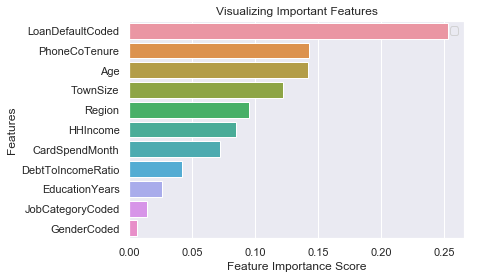

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()